<a href="https://colab.research.google.com/github/lukgol89/Data_Science/blob/main/Computer_Vision/Apple_dieases_CV_128.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import shutil
import os
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 16
EPOCHS = 35
CHANNELS = 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/Apple_diease/train",
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 9748 files belonging to 5 classes.


In [ ]:
test_set = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/Data/Apple_diease/test",
    shuffle =True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2959 files belonging to 5 classes.


In [ ]:
train_names = train_set.class_names
train_names

[' alternaria', 'apple_scab', 'black_rot', 'cedar_apple_rust', 'healthy']

In [ ]:
n_classes = len(train_names)
n_classes

5

Counting data

In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train/ alternaria" | wc -l

2258


In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train/apple_scab" | wc -l

1735


In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train/black_rot" | wc -l

1987


In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train/cedar_apple_rust" | wc -l

1760


In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train/healthy" | wc -l

2008


In [ ]:
!ls "/content/drive/MyDrive/Data/Apple_diease/train" | wc -l

5


In [ ]:
for image_batch, label_batch in train_set.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(16, 128, 128, 3)
[1 0 2 4 2 0 4 1 2 3 2 0 0 4 0 0]


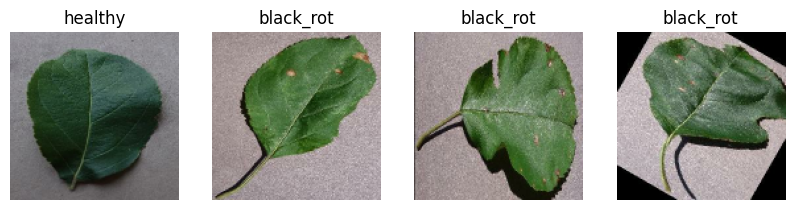

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train_set.take(1):
  for i in range (4):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_names[label_batch[i]])
    plt.axis("off")

In [ ]:
len(train_set)

610

In [ ]:
len(test_set)

185

In [ ]:
# # separation validation set from test set
# val_set=test_set.take(30)
# len(val_set)

In [ ]:
# test_set = test_set.skip(30)

In [ ]:
# test_set splited to test_set and val_set

def get_test_set_val_set (ts, val_split=0.5, test_split=0.5, shuffle=True, shuffle_size=10000):

  ts_size = len(ts)

  if shuffle:
    ts = ts.shuffle(shuffle_size, seed = 12)
  test_size = int(test_split*ts_size)
  val_size = int(val_split*ts_size)

  test_set = ts.take(test_size)
  val_set = ts.skip(test_size).take(val_size)

  return test_set, val_set

In [ ]:
test_set, val_set = get_test_set_val_set(test_set)

In [ ]:
len(test_set)

92

In [ ]:
len(val_set)

92

In [ ]:
len(train_set)

610

Building model

In [ ]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),

])

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = n_classes
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 8)

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation="relu", input_shape = input_shape),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation="relu"),
    layers.MaxPool2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 128, 128, 3)         0         
                                                                 
 sequential_1 (Sequential)   (16, 128, 128, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 126, 126, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (16, 63, 63, 32)          0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 61, 61, 64)          18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 30, 30, 64)          0         
 g2D)                                                 

In [ ]:
model.compile(
    optimizer = "adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [ ]:
history = model.fit(
    train_set,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_set,
    callbacks=[es]
)

Epoch 1/35


In [ ]:
history.params

In [ ]:
es_n = len(history.history['loss'])
es_n

In [ ]:
scores = model.evaluate(test_set)

In [ ]:
# number of processed epoch
es_list = list(range(1,es_n+1))

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot((es_list), acc, label="Training Accuracy")
plt.plot((es_list), val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot((es_list), loss, label="Training Loss")
plt.plot((es_list), val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
# plt.figure(figsize=(10,10))
# for image_batch, label_batch in train_set.take(1):
#   for i in range (4):
#     ax = plt.subplot(3,4,i+1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title(train_names[label_batch[i]])
#     plt.axis("off")

In [ ]:
# checking and showing prediction
plt.figure(figsize=(5,5))
for images_bach, labels_bach in test_set.take(1):

  first_image = (images_bach[i].numpy().astype("uint8"))
  first_label = labels_bach[i].numpy()

  print("first image to predict")
  plt.imshow(first_image)
  plt.axis("off")
  print("actual label: ", train_names[first_label])

  batch_prediction = model.predict(images_bach)
  print("predicted label: ", train_names[np.argmax(batch_prediction[i])])


In [ ]:
model_version = max([int(i) for i in os.listdir("/content/drive/MyDrive/Data/Apple_diease/models") + [0]])+1

In [ ]:

model.save("/content/drive/MyDrive/Data/Apple_diease/models/proba")